### Upload a data

`X_train` - train image dataset
`Y_train` - train label dataset
`X_test` - test image dataset
`Y_test` - test label dataset

In [1]:
import tensorflow as tf
import os
from PIL import Image
import random
import matplotlib.pyplot as plt
import pennylane as qml
from pennylane import numpy as np
from IPython.display import display

In [2]:
import json
train_json = './Data_Sources/al5083/train/train.json'

with open(train_json, 'r') as json_file:
    train_data_json = json.load(json_file)

label_count = [0, 0, 0, 0, 0, 0]
for l in train_data_json:
    label_count[train_data_json[l]] += 1

label_count

[8758, 1783, 6325, 4028, 2953, 2819]

In [3]:
# Define names
label_names = ["good weld", "burn through", "contamination", "lack of fusion", "misalignment", "lack of penetration"]

# Define labels
labels = [0, 1, 2, 3, 4, 5]

# Number of classes
num_classes = 6

# Label is converted into a binary vector where only the position corresponding to the label is set to 1, and all other positions are set to 0.
one_hot_encoding_test = [[1 if i == label else 0 for i in range(num_classes)] for label in labels]

In [4]:
all_data = []
image_size = (16, 16)
label_count = [0, 0, 0, 0]

In [5]:
import os
def load_data(path):
    for folder in os.listdir(path):
        folder_path = os.path.join(path, folder)
        if(os.path.isdir(folder_path)):
            for img_name in os.listdir(folder_path):

                img_path = os.path.join(folder_path, img_name)
                key_name = folder + '/' + img_name
                label = train_data_json[key_name]

                if label == 4 or label == 5:
                    continue
                if(label_count[label] > 100):
                    continue

                label_count[label] += 1
                image = Image.open(img_path).resize(image_size)
                #image = tf.convert_to_tensor(image)
                image = np.array(image, dtype=np.int32)
                all_data.append((image, label))

                if(len(all_data)%100==0):
                    print(f"Total images loaded : {len(all_data)}, Label count : {label_count}", end = '\r')

In [6]:
load_data('./Data_Sources/al5083/train')

In [7]:
random.shuffle(all_data)

In [8]:
X = []
Y = []
for data in all_data:
    X.append(data[0])
    Y.append(data[1])

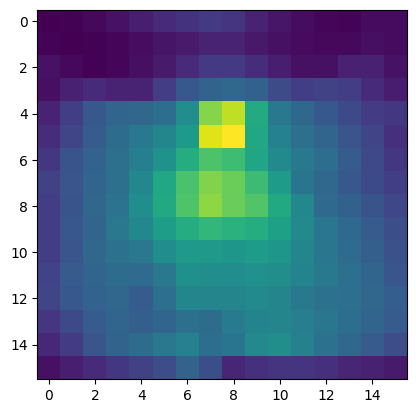

Label : lack of fusion


In [9]:
import matplotlib.pyplot as plt
rand_img = np.random.randint(low = 0, high = len(X))
plt.imshow(X[rand_img])
plt.show()
print(f"Label : {label_names[Y[rand_img]]}")

Split the data into training sets: 80% of the total data for training

In [10]:
# Split the data into : 80% of the total data for training,20% of the total data for testing
total_data = len(X)
X_train, Y_train = X[:int(total_data*0.8)], Y[:int(total_data*0.8)]
X_test, Y_test = X[int(total_data*0.8):], Y[int(total_data*0.8):]

This means converting the 2D array of image pixels (16x16 pixels) into a 1D array.

In [11]:
# This means converting the 2D array of image pixels (16x16 pixels) into a 1D array.
# Reshape each image in X_train to 1D array
X_train = [x.reshape(-1) for x in X_train]

# Reshape each image in X_test to 1D array
X_test = [x.reshape(-1) for x in X_test]

Training set:

In [21]:
values, counts = np.unique( Y_train, return_counts=True)
print(values)
print(counts)

[0 1 2 3]
[73 82 86 82]


Testing set:

In [22]:
values, counts = np.unique(Y_test, return_counts=True)
print(values)
print(counts)

[0 1 2 3]
[28 19 15 19]


### Model

PEPS architecture - circuit

In [14]:
import pennylane as qml
from pennylane import numpy as np
dev = qml.device("default.qubit", wires=8)

@qml.qnode(dev)
def circuit_peps(image, template_weights):
    qml.AmplitudeEmbedding(features=image, wires=range(8), normalize=True)

    i = 0

    qml.RY(template_weights[i], wires=3)
    i = i+1
    qml.RY(template_weights[i], wires=4)
    i = i+1
    qml.CNOT(wires=[3, 4])

    qml.RY(template_weights[i], wires=2)
    i = i+1
    qml.RY(template_weights[i], wires=3)
    i = i+1
    qml.CNOT(wires=[2, 3])

    qml.RY(template_weights[i], wires=4)
    i = i+1
    qml.RY(template_weights[i], wires=5)
    i = i+1
    qml.CNOT(wires=[4, 5])

    for j in range(1, 6, 2):
        qml.RY(template_weights[i], wires=j)
        i = i+1
        qml.RY(template_weights[i], wires=j+1)
        i = i+1
        qml.CNOT(wires=[j, j+1])

    for j in range(0, 7, 2):
        qml.RY(template_weights[i], wires=j)
        i = i+1
        qml.RY(template_weights[i], wires=j+1)
        i = i+1
        qml.CNOT(wires=[j, j+1])

    for j in range(1, 6, 2):
        qml.RY(template_weights[i], wires=j)
        i = i+1
        qml.RY(template_weights[i], wires=j+1)
        i = i+1
        qml.CNOT(wires=[j, j+1])

    qml.RY(template_weights[i], wires=2)
    i = i+1
    qml.RY(template_weights[i], wires=3)
    i = i+1
    qml.CNOT(wires=[2, 3])

    qml.RY(template_weights[i], wires=4)
    i = i+1
    qml.RY(template_weights[i], wires=5)
    i = i+1
    qml.CNOT(wires=[4, 5])

    qml.RY(template_weights[i], wires=3)
    i = i+1
    qml.RY(template_weights[i], wires=4)
    i = i+1
    qml.CNOT(wires=[3, 4])


    return qml.probs(wires = [3, 4])

weights = np.random.random(size=[32, 1])
#qml.draw_mpl(circuit_peps, expansion_strategy="device")(X_train[0], weights)
circuit_peps(X_train[0], weights)

tensor([[0.12873753, 0.15497383, 0.37067129, 0.34561735]], requires_grad=True)

Cost function with Cross-Entropy Loss

In [15]:
def costfunc(params):
    cost = 0
    y_true = [np.array([1, 0, 0, 0]), np.array([0, 1, 0, 0]), np.array([0, 0, 1, 0]), np.array([0, 0, 0, 1])]
    len_X_train = len(X_train)
    for i in range(len_X_train):
        prob = circuit_peps(X_train[i], params)
        if Y_train[i] == 0:
            cost -= 1/len_X_train * np.sum(np.sum(y_true[0].astype(float)*np.log(prob.astype(float))))
        elif Y_train[i] == 1:
            cost -= 1/len_X_train * np.sum(np.sum(y_true[1].astype(float)*np.log(prob.astype(float))))
        elif Y_train[i] == 2:
            cost -= 1/len_X_train * np.sum(np.sum(y_true[2].astype(float)*np.log(prob.astype(float))))
        elif Y_train[i] == 3:
            cost -= 1/len_X_train * np.sum(np.sum(y_true[3].astype(float)*np.log(prob.astype(float))))
    return cost

training the circuit parameters

In [16]:
# training the circuit parameters
x2 = np.random.random(size=[32, 1], requires_grad=True)
params = x2[:]
optimizer = qml.AdamOptimizer(stepsize=0.1)

for k in range(100):
    if k % 5 == 0:
        print(f"Step {k}, cost: {costfunc(params)}")
    params = optimizer.step(costfunc, params)
print(params)

Step 0, cost: 1.3208564377267116
Step 5, cost: 1.1823051682138255
Step 10, cost: 1.1674345594696223
Step 15, cost: 1.1575947326696585
Step 20, cost: 1.1490309587724103
Step 25, cost: 1.1409913078584855
Step 30, cost: 1.1342929491757279
Step 35, cost: 1.1312570996124969
Step 40, cost: 1.1288944016059448
Step 45, cost: 1.1265888948871845
Step 50, cost: 1.1243693990595809
Step 55, cost: 1.1230868160506686
Step 60, cost: 1.1225465241968193
Step 65, cost: 1.1220176356117064
Step 70, cost: 1.1216901215918536
Step 75, cost: 1.1215141991811468
Step 80, cost: 1.1212854848823077
Step 85, cost: 1.120958552883128
Step 90, cost: 1.1206152395844633
Step 95, cost: 1.120247914336163
[[ 0.24579633]
 [-0.06336454]
 [ 0.26719121]
 [-0.06481993]
 [ 1.56614255]
 [ 1.56271783]
 [ 0.69671569]
 [-0.28726877]
 [ 0.15947218]
 [ 0.18060022]
 [ 0.17565438]
 [ 1.00375459]
 [ 0.2266194 ]
 [-0.25750108]
 [-0.02083074]
 [-0.4699564 ]
 [ 0.52347125]
 [ 1.24121563]
 [ 0.13527372]
 [-0.20762295]
 [ 0.02097157]
 [ 1.2312

In [17]:
params

tensor([[ 0.24579633],
        [-0.06336454],
        [ 0.26719121],
        [-0.06481993],
        [ 1.56614255],
        [ 1.56271783],
        [ 0.69671569],
        [-0.28726877],
        [ 0.15947218],
        [ 0.18060022],
        [ 0.17565438],
        [ 1.00375459],
        [ 0.2266194 ],
        [-0.25750108],
        [-0.02083074],
        [-0.4699564 ],
        [ 0.52347125],
        [ 1.24121563],
        [ 0.13527372],
        [-0.20762295],
        [ 0.02097157],
        [ 1.23122822],
        [ 0.42913509],
        [ 1.25642007],
        [ 0.26656383],
        [-0.19001233],
        [ 0.23149406],
        [-0.34829223],
        [ 0.29711902],
        [ 1.76503088],
        [-0.00237741],
        [-0.19549177]], requires_grad=True)

### Checking the circuit on first X_test data.

In [18]:
x = circuit_peps(X_test[0], params)
np.argmax(x)

3

In [19]:
Y_test[0]

3

### Calculating accuracy
On the test set extracted from the training set. When predicted_label does not match test_label, both values are displayed.

In [20]:
test_correct = 0

for img, true_label in zip(X_test, Y_test):
    # Get predictions from the quantum circuit
    predictions = circuit_peps(img, params)

    # Determine the predicted label
    predicted_label = np.argmax(predictions)

    # Increment correct count if prediction matches the true label
    if predicted_label == true_label:
        test_correct += 1
    else:
        print("Predicted label:", predicted_label)
        print("True label",true_label)

# Calculate and print the testing accuracy percentage
accuracy = 100 * test_correct / len(X_test)
print(f"Testing accuracy: {accuracy:.2f}%")

Predicted label: 3
True label 1
Predicted label: 3
True label 1
Predicted label: 3
True label 1
Predicted label: 3
True label 1
Predicted label: 3
True label 1
Predicted label: 3
True label 1
Predicted label: 3
True label 1
Testing accuracy: 91.36%


We can see that it is most often mistaken in recognizing class 1. The model says it is 3 when in fact it is 1.

### Summary
Classification for 4 class, PEPS circuit.
Using 400 images from train dataset.
Training set: images [73 82 86 82] per classes [0 1 2 3]
Testing set: images [28 19 15 19] per classes [0,1,2,3]


Testing accuracy: 91.36%
